# 1D Three Phase Simulation of Alloys and PINN model development 


This notebook contains the simulation of 1D Phase change of aluminium alloy. There will be three phases (solid,liquid and mushy).   

The approach used is finite difference method and the physics involved in heat conduction.

## Import Libraries

In [147]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools

from ht_simNy import sim1d



from pyDOE2 import fullfact
from pyDOE2 import fracfact

import statsmodels.api as sm

from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
import seaborn as sns
from scipy import stats


### <center>Pareto analysis</center>

<p style="font-size:12px; font-family:'Times New Roman', sans-serif; line-height:1.6;">

In this section sensitivity study of the soldification is performed with respect to different material properties and  initial/boundary conditions. The soldification time is the variable under study and it is calcualted based on solution of 1D heat transfer and phase change equation.



Here the parameters/factors are as follows:-

1. Density for material in liquid state $\rho_l$.<br>
2. Density for material in solid state $\rho_s$.<br>
3. Latent Heat of Fusion <br>
4. Specific heat of material in liquid state $C_{pl}$ <br>
5. Specific heat of material in solid state $C_{ps}$ <br>
6. Thermal Conductivity of material in liquid state $k_l$<br>
7. Thermal Conductivity of material in solid state $k_s$ <br>


Boundary conditions:-
8. Surrounding Temperature <br>

Initial Conditions:-

9. Initial_temperature <br>


</p>




The number of runs are large so a fractional factorial design is adopted.

## Fractional Factorial Design

In [148]:
#Create a fractional factorial design

from pyDOE2 import fracfact

num_levels = 2
levels = [0, 1]
num_vars = 11
design2 = fracfact('a b c d e f abc abd ade aef bcd bcf')
L_level = 0.99
R_level = 1.01
perc_change = [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.3, 0.03, 0.60, 0.30,0.30]


factor_levels = {
    'rho_l': [2386.2, 2533.8], #A
    'rho_s': [2628.7, 2791.3], #B
    'k_l': [100.88,107.12],    #C
    'k_s': [93.31, 99.08],      #D
    'cp_l': [1207.94, 1282.65], #E
    'cp_s': [934.11, 991.89],  #F
    'Surr_temp': [285.0,298.0], #G
    'L_fusion': [377330.0, 400670.0], #H
    'temp_init': [901.0, 925.0], # J
    'heat_transfer_coefficient_left': [10.0, 15.0], #K
    'heat_transfer_coefficient_right': [10.0, 15.0], #L
    'Length': [10.0e-3, 20.0e-3],      #M
}


factor_names = list(factor_levels.keys())
# print (313.0 *(1+perc_change[6]))
# Create a DataFrame from the fractional factorial design
doe_df_sol_time_fracfact = pd.DataFrame(design2, columns=factor_names)

for factor, levels in factor_levels.items():
    doe_df_sol_time_fracfact[factor] = doe_df_sol_time_fracfact[factor].map({-1: levels[0], 1: levels[1]})
   
    
print(doe_df_sol_time_fracfact.shape)

(64, 12)


In [149]:
FracFact_doe_sol_time = doe_df_sol_time_fracfact.copy()

FracFact_doe_sol_time['Lowest_Niyama'] = [0.0] * FracFact_doe_sol_time.shape[0] # Data frame inclduing the response variable

print(FracFact_doe_sol_time.shape)



(64, 13)


In [150]:
for i in range(FracFact_doe_sol_time.shape[0]):
    input_values = FracFact_doe_sol_time.iloc[i,:-1].values
    if input_values.size > 0:
        k = sim1d(*input_values)
        FracFact_doe_sol_time.at[i, 'Lowest_Niyama'] = k
        

    

### Histogram of the Total Solidifcation time is plotted

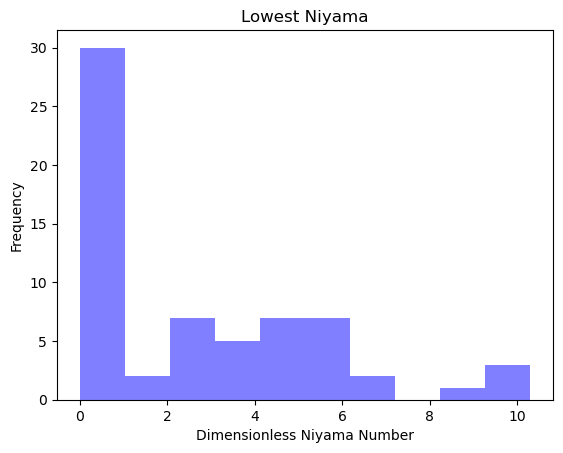

In [151]:
plt.hist(FracFact_doe_sol_time['Lowest_Niyama'], bins=10, alpha=0.5, color='b')
plt.title('Lowest Niyama')
plt.xlabel('Dimensionless Niyama Number')
plt.ylabel('Frequency')
plt.show()

### Regression model is developed

In [152]:


# Create the formula for the ANOVA
formula = 'Lowest_Niyama ~ C(rho_l) + C(rho_s) + C(k_l) + C(k_s) + \
           C(cp_l) + C(cp_s) + C(Surr_temp) + C(L_fusion) \
         + C(temp_init)+ C(heat_transfer_coefficient_left) + C(heat_transfer_coefficient_right)+ C(Length) \
         + C(rho_l):C(k_s) + C(rho_s):C(cp_l) + C(k_l):C(cp_s) + C(Surr_temp):C(L_fusion) + \
              C(temp_init):C(heat_transfer_coefficient_right) + C(heat_transfer_coefficient_left):C(Length)'

# Fit the model
model = sm.OLS.from_formula(formula, data=FracFact_doe_sol_time).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          Lowest_Niyama   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                 -0.069
Method:                 Least Squares   F-statistic:                    0.7597
Date:                Mon, 12 Aug 2024   Prob (F-statistic):              0.726
Time:                        10:23:18   Log-Likelihood:                -147.99
No. Observations:                  64   AIC:                             332.0
Df Residuals:                      46   BIC:                             370.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

### Plot of Residuals

The plots of the residuals vs. fitted values are shown below


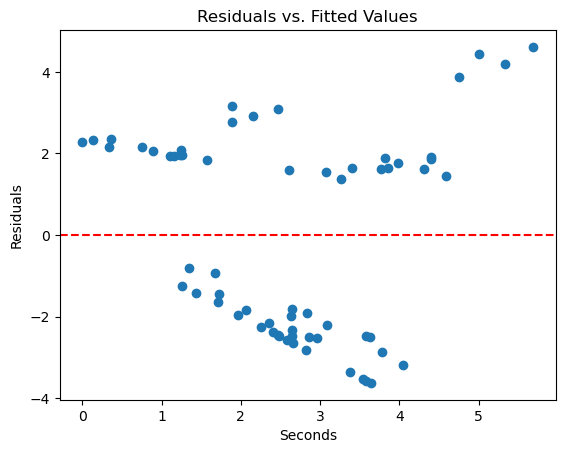

In [153]:
residuals_ols = model.resid
FracFact_doe_sol_time['Residuals'] =residuals_ols
print (f"The plots of the residuals vs. fitted values are shown below")
# Plot residuals vs. fitted values
plt.scatter(model.fittedvalues, residuals_ols)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Seconds')
plt.ylabel('Residuals')
plt.show()


# print (f"This is followed by the histogram of the residuals")
# plt.hist(residuals_ols, bins=10, alpha=0.5, color='b')
# plt.title('Residuals Histogram')
# plt.xlabel('Seconds')
# plt.ylabel('Frequency')
# plt.show()

### Normality of Residuals check

In [154]:
from scipy.stats import shapiro

# Shapiro-Wilk Test
stat, p_value = shapiro(residuals_ols)
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p_value)

if p_value > 0.05:
    print('The residuals are normally distributed (fail to reject H0).')
else:
    print('The residuals are not normally distributed (reject H0).')


Shapiro-Wilk Test Statistic: 0.8832112840734687
p-value: 1.972138912127603e-05
The residuals are not normally distributed (reject H0).


The interaction was observed among rho_l and cp_s , rho_s and cp_s , cp_l and cp_s  & cp_s and temp_init.

## Center points check

In [155]:
num_center_points = 1

center_point = {factor: np.mean(levels) for factor,levels in factor_levels.items()}

center_pt_df = pd.DataFrame([center_point] * num_center_points, columns=factor_names)

doe_center_pt = pd.concat([doe_df_sol_time_fracfact, center_pt_df], ignore_index=True)
print(doe_center_pt.shape)

(65, 12)


### Factorial design

In [156]:
Fractional_Factorial_doe_center_pt = doe_center_pt.copy()

Fractional_Factorial_doe_center_pt['Lowest_Niyama'] = [0.0] * Fractional_Factorial_doe_center_pt.shape[0]

print(Fractional_Factorial_doe_center_pt.shape)

(65, 13)


In [157]:
for i in range(Fractional_Factorial_doe_center_pt.shape[0]):
    input_values = Fractional_Factorial_doe_center_pt.iloc[i,:-1].values
    k= sim1d(*input_values)
    Fractional_Factorial_doe_center_pt.at[i, 'Lowest_Niyama'] = k

CSV file generator

### Plot

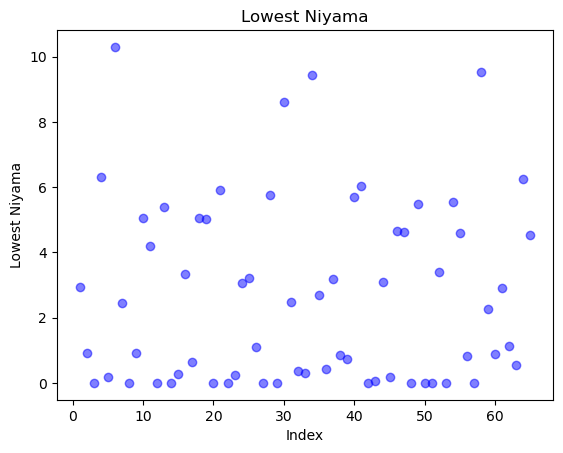

In [158]:
counts = range(1,len(Fractional_Factorial_doe_center_pt)+1)

plt.scatter(counts,Fractional_Factorial_doe_center_pt['Lowest_Niyama'], alpha=0.5, color='b')
plt.title('Lowest Niyama')
plt.xlabel('Index')
plt.ylabel('Lowest Niyama')
plt.show()

### Regression Model

In [159]:
formula5 = 'Lowest_Niyama ~ rho_l + rho_s + k_l + k_s + \
           cp_l + cp_s + Surr_temp + L_fusion \
         + temp_init+ heat_transfer_coefficient_left + heat_transfer_coefficient_right+ Length'

model5 = sm.OLS.from_formula(formula5, data=Fractional_Factorial_doe_center_pt.iloc[:-1]).fit()
print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:          Lowest_Niyama   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     1.185
Date:                Mon, 12 Aug 2024   Prob (F-statistic):              0.319
Time:                        10:26:28   Log-Likelihood:                -148.04
No. Observations:                  64   AIC:                             322.1
Df Residuals:                      51   BIC:                             350.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [160]:
y_pred = model5.predict(Fractional_Factorial_doe_center_pt.iloc[-1])
print(f'Predicted value of the response variable: {y_pred.values[0]}')
error = Fractional_Factorial_doe_center_pt.iloc[-1]['Lowest_Niyama'] - y_pred.values[0]
print(f'Prediction error: {error}')

# Perform a t-test to determine if the prediction error is significantly different from zero
# Extract the residuals from the model
residuals = model5.resid

# Calculate the mean and standard error of the residuals
mean_residuals = np.mean(residuals)
std_error = np.std(residuals, ddof=1) / np.sqrt(len(residuals))

# Perform t-test on the prediction error
t_statistic = (error - mean_residuals) / std_error
df = len(residuals) - 1  # Degrees of freedom
p_value = 2 * (1 - stats.t.cdf(np.abs(t_statistic), df))

print(f't-statistic: {t_statistic}')
print(f'p-value: {p_value}')

# Interpretation of the t-test result
if p_value < 0.05:
    print("The prediction error is significantly different from zero (reject null hypothesis).")
else:
    print("The prediction error is not significantly different from zero (fail to reject null hypothesis).")

Predicted value of the response variable: 2.6448437499995094
Prediction error: 1.8951562500004906
t-statistic: 6.151170312566579
p-value: 5.8627922516762965e-08
The prediction error is significantly different from zero (reject null hypothesis).


The plots of the residuals vs. fitted values are shown below


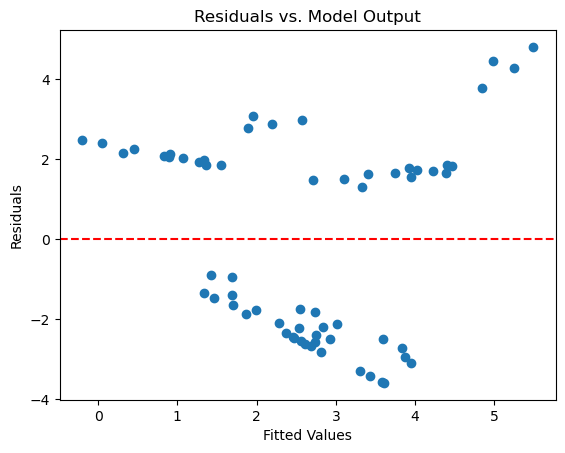

In [161]:
residual5 = model5.resid
Fractional_Factorial_doe_center_pt['Residuals'] =residual5
print (f"The plots of the residuals vs. fitted values are shown below")
# Plot residuals vs. fitted values
plt.scatter(model5.fittedvalues, residual5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Model Output')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()



#### Anova

In [162]:
from statsmodels.formula.api import ols

formula7 = 'Lowest_Niyama ~ rho_l + rho_s + k_l + k_s + \
           cp_l + cp_s + Surr_temp + L_fusion \
         + temp_init+ heat_transfer_coefficient_left + heat_transfer_coefficient_right+ Length'

model7 = ols(formula7, data=Fractional_Factorial_doe_center_pt).fit()

anova_results7 = sm.stats.anova_lm(model7, typ=2)

print(anova_results7)

                                     sum_sq    df         F    PR(>F)
rho_l                             18.136952   1.0  2.441621  0.124220
rho_s                             14.015664   1.0  1.886808  0.175456
k_l                                0.002889   1.0  0.000389  0.984341
k_s                                0.183827   1.0  0.024747  0.875608
cp_l                               0.005439   1.0  0.000732  0.978516
cp_s                               0.043577   1.0  0.005866  0.939242
Surr_temp                          0.226814   1.0  0.030534  0.861963
L_fusion                           0.167077   1.0  0.022492  0.881366
temp_init                         44.039814   1.0  5.928699  0.018363
heat_transfer_coefficient_left     1.131564   1.0  0.152333  0.697910
heat_transfer_coefficient_right    0.579502   1.0  0.078013  0.781116
Length                            28.182827   1.0  3.794010  0.056844
Residual                         386.268616  52.0       NaN       NaN


#### Main effects with center points

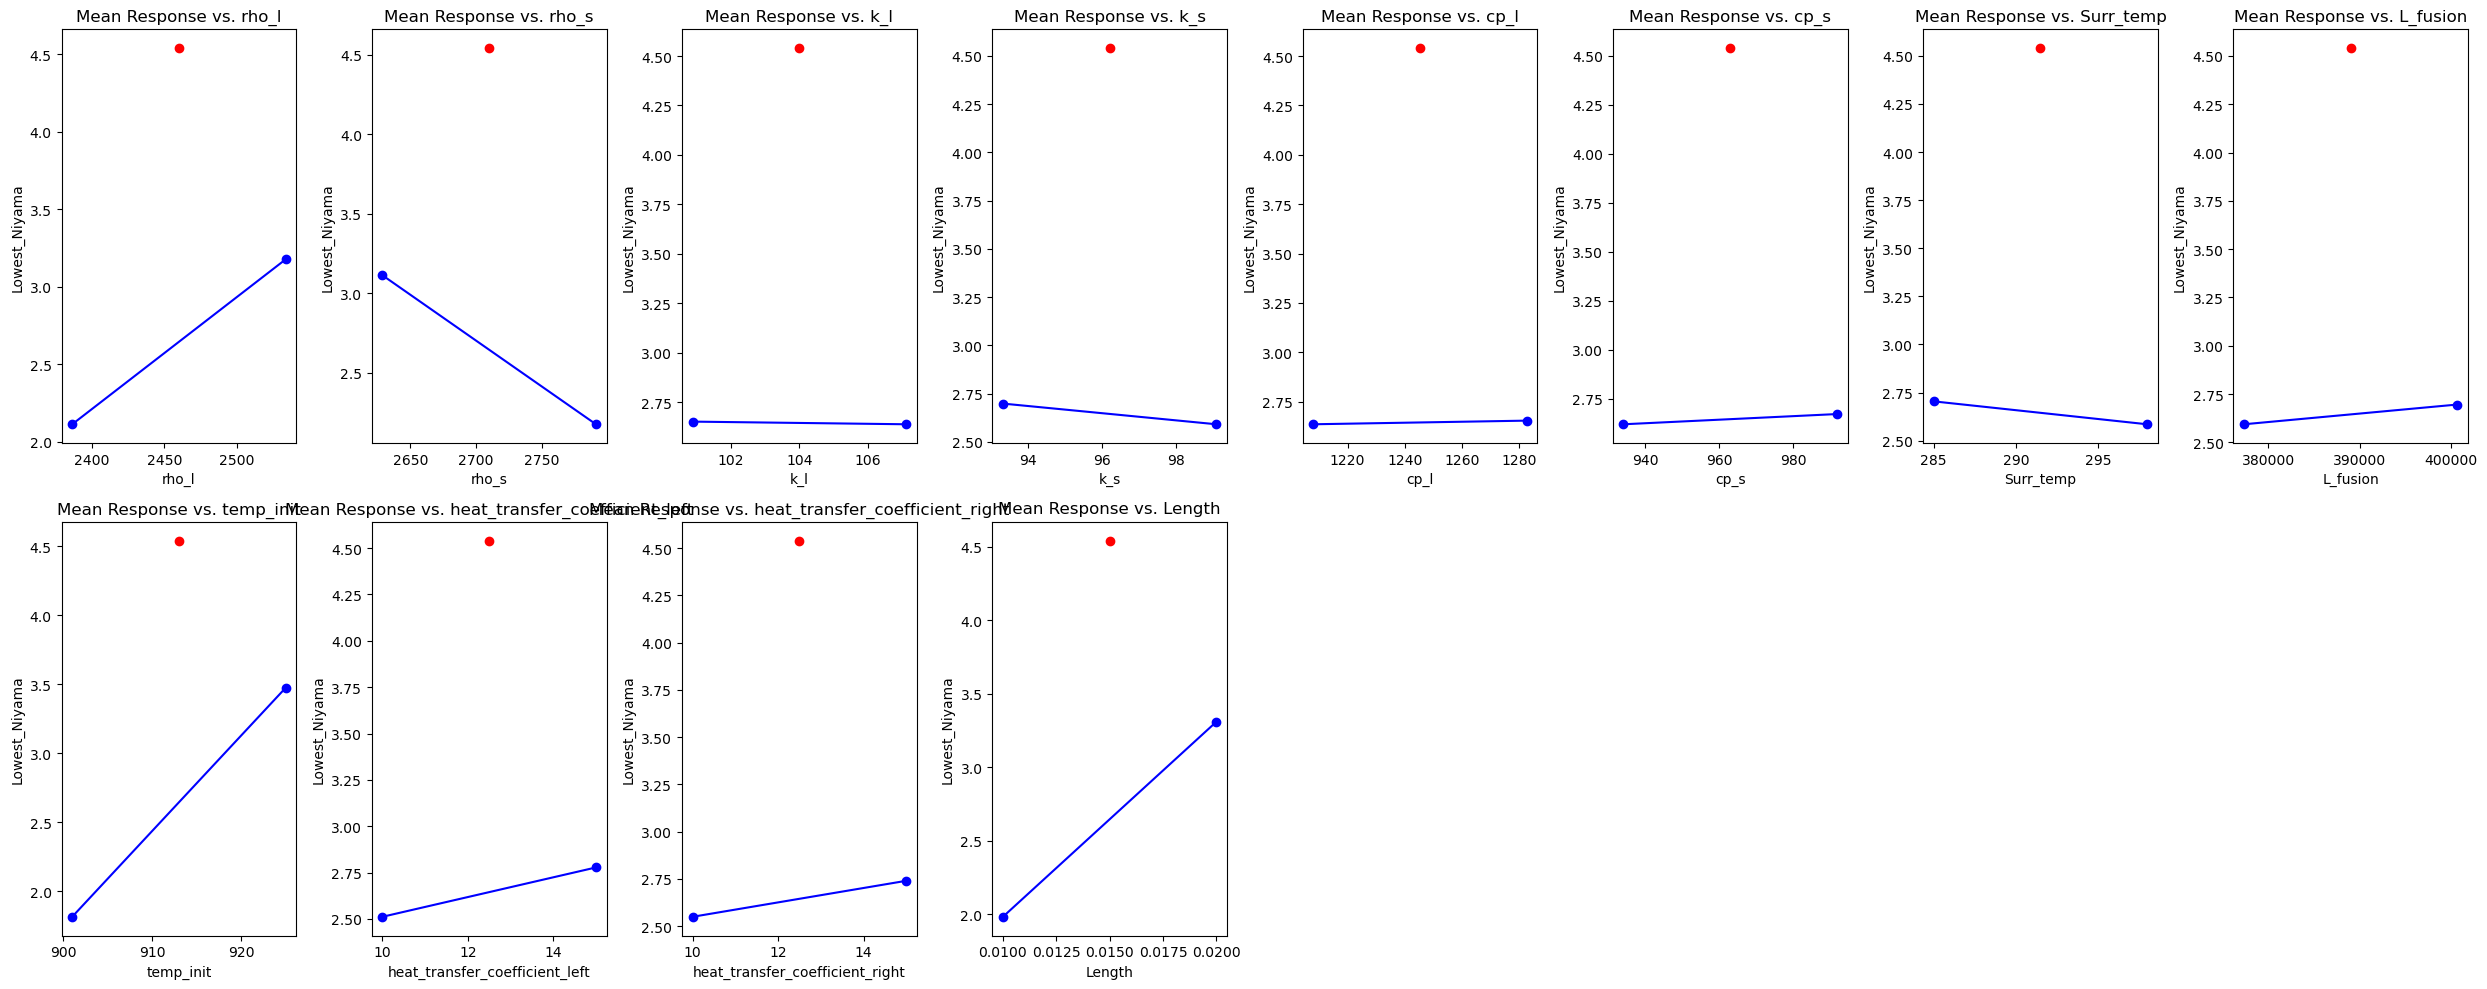

In [163]:
mean_response_center = {}

for factor in factor_names:
    mean_response_center[factor] = Fractional_Factorial_doe_center_pt.groupby(factor)['Lowest_Niyama'].mean()

# print(mean_response_center)
plt.figure(figsize=(25, 10))

for i, factor in enumerate(factor_names):
    plt.subplot(2, 8, i+1)

    mean_responses = mean_response_center[factor]


    center_point = mean_responses.iloc[-2]
    center_point_index = mean_responses.index[-2]
    # print(center_point_index,center)
    non_center_points_low = mean_responses.iloc[0]
    non_center_points_low_index = mean_responses.index[0]
    non_center_points_high = mean_responses.iloc[-1]
    non_center_points_high_index = mean_responses.index[-1]

    plt.plot([non_center_points_low_index,non_center_points_high_index], [non_center_points_low,non_center_points_high],marker='o', color='b')
    
    # Plotting the center points
    center_points = mean_response_center[factor]
    plt.scatter([center_point_index], [center_point], color='r', label='Center Points')
    
    # # Plot all individual data points for the factor
    # all_data_points = Fractional_Factorial_doe_center_pt.groupby(factor)['Lowest_Niyama']
    # for key, group in all_data_points:
    #     plt.scatter([key]*len(group), group, alpha=0.3, color='gray')

    plt.title(f'Mean Response vs. {factor}')
    plt.xlabel(factor)
    plt.ylabel('Lowest_Niyama')

plt.tight_layout()
plt.show()


In [164]:
formula8 = 'Lowest_Niyama ~ rho_l + rho_s + k_l + k_s + \
           cp_l + cp_s + Surr_temp + L_fusion \
         + temp_init+ heat_transfer_coefficient_left + heat_transfer_coefficient_right+ Length + rho_l*rho_s + rho_l:rho_s + rho_l:heat_transfer_coefficient_left + rho_l:heat_transfer_coefficient_right + rho_l:Length + rho_s:heat_transfer_coefficient_left + rho_s:heat_transfer_coefficient_right + rho_s:Length + heat_transfer_coefficient_left:heat_transfer_coefficient_right + heat_transfer_coefficient_left:Length + heat_transfer_coefficient_right:Length'

In [165]:
model8 = ols(formula8, data=Fractional_Factorial_doe_center_pt).fit()
print(model8.summary())

                            OLS Regression Results                            
Dep. Variable:          Lowest_Niyama   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     22.16
Date:                Mon, 12 Aug 2024   Prob (F-statistic):           1.56e-16
Time:                        10:26:30   Log-Likelihood:                -75.717
No. Observations:                  65   AIC:                             197.4
Df Residuals:                      42   BIC:                             247.4
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [166]:
import statsmodels.api as sm
import pandas as pd
import itertools

# Define the list of variables
variables = ['rho_l', 'rho_s', 'k_l', 'k_s', 'cp_l', 'cp_s', 'Surr_temp', 'L_fusion', 'temp_init', 'heat_transfer_coefficient_left', 'heat_transfer_coefficient_right', 'Length']

# Generate interaction terms
combinations = list(itertools.combinations(variables, 2))
interaction_terms = ['{}*{}'.format(a, b) for a, b in combinations]

# Generate quadratic (axial) terms
quadratic_terms = ['np.power({}, 2)'.format(var) for var in variables]

# Base formula with main effects
base_formula = 'Lowest_Niyama ~ ' + ' + '.join(variables)

# Combine all terms into the final formula
all_terms = variables + interaction_terms + quadratic_terms
final_formula = 'Lowest_Niyama ~ ' + ' + '.join(all_terms)

# Print the final formula
print("Final Formula for Statsmodels:")
print(final_formula)

# Assuming Fractional_Factorial_doe_center_pt is your DataFrame with the necessary data
# Fit the model using all but the last row of the DataFrame
model9 = sm.OLS.from_formula(final_formula, data=Fractional_Factorial_doe_center_pt).fit()

# Print the model summary
print(model9.summary())


Final Formula for Statsmodels:
Lowest_Niyama ~ rho_l + rho_s + k_l + k_s + cp_l + cp_s + Surr_temp + L_fusion + temp_init + heat_transfer_coefficient_left + heat_transfer_coefficient_right + Length + rho_l*rho_s + rho_l*k_l + rho_l*k_s + rho_l*cp_l + rho_l*cp_s + rho_l*Surr_temp + rho_l*L_fusion + rho_l*temp_init + rho_l*heat_transfer_coefficient_left + rho_l*heat_transfer_coefficient_right + rho_l*Length + rho_s*k_l + rho_s*k_s + rho_s*cp_l + rho_s*cp_s + rho_s*Surr_temp + rho_s*L_fusion + rho_s*temp_init + rho_s*heat_transfer_coefficient_left + rho_s*heat_transfer_coefficient_right + rho_s*Length + k_l*k_s + k_l*cp_l + k_l*cp_s + k_l*Surr_temp + k_l*L_fusion + k_l*temp_init + k_l*heat_transfer_coefficient_left + k_l*heat_transfer_coefficient_right + k_l*Length + k_s*cp_l + k_s*cp_s + k_s*Surr_temp + k_s*L_fusion + k_s*temp_init + k_s*heat_transfer_coefficient_left + k_s*heat_transfer_coefficient_right + k_s*Length + cp_l*cp_s + cp_l*Surr_temp + cp_l*L_fusion + cp_l*temp_init + cp_l*h

### Study of interaction and quadratic effects


In [167]:
formula11 = 'Lowest_Niyama ~ rho_l + rho_s + k_l + k_s \
             + cp_l + cp_s + Surr_temp + L_fusion + temp_init + \
            heat_transfer_coefficient_left + heat_transfer_coefficient_right + Length + \
            rho_l*rho_s + rho_l*k_l + rho_l*cp_l + rho_l*cp_s + rho_l*Surr_temp + rho_l*L_fusion + rho_l*heat_transfer_coefficient_left + \
             + rho_l*Length + rho_s*k_l + rho_s*cp_l + \
            rho_s*cp_s + rho_s*Surr_temp + rho_s*L_fusion  + rho_s*heat_transfer_coefficient_left + \
            rho_s*heat_transfer_coefficient_right + rho_s*Length + k_l*cp_l  + k_l*Surr_temp + k_l*L_fusion +\
             + k_l*heat_transfer_coefficient_left  + k_l*Length + k_s*cp_l  + \
            k_s*Surr_temp + k_s*heat_transfer_coefficient_left +  \
            cp_l*cp_s + cp_l*Surr_temp + cp_l*L_fusion + cp_l*temp_init + cp_l*heat_transfer_coefficient_left + \
            cp_l*Length +  cp_s*L_fusion + cp_s*temp_init + cp_s*heat_transfer_coefficient_left + cp_s*heat_transfer_coefficient_right + \
            cp_s*Length + Surr_temp*L_fusion + Surr_temp*temp_init + Surr_temp*heat_transfer_coefficient_left +  \
            Surr_temp*Length + L_fusion*heat_transfer_coefficient_left + L_fusion*heat_transfer_coefficient_right + L_fusion*Length + \
            + heat_transfer_coefficient_left*heat_transfer_coefficient_right + \
            heat_transfer_coefficient_left*Length + heat_transfer_coefficient_right*Length + np.power(rho_l, 2) + np.power(rho_s, 2) + np.power(k_l, 2) + np.power(cp_l, 2) + np.power(cp_s, 2) + \
                np.power(Surr_temp, 2) + np.power(L_fusion, 2) + np.power(heat_transfer_coefficient_left, 2) + np.power(Length, 2)'

In [168]:
model10 = sm.OLS.from_formula(formula11, data=Fractional_Factorial_doe_center_pt).fit()

# Print the model summary
print(model10.summary())

                            OLS Regression Results                            
Dep. Variable:          Lowest_Niyama   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     8.572
Date:                Mon, 12 Aug 2024   Prob (F-statistic):           6.64e-07
Time:                        10:26:30   Log-Likelihood:                -65.310
No. Observations:                  65   AIC:                             216.6
Df Residuals:                      22   BIC:                             310.1
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [214]:
formula12 = 'Lowest_Niyama ~  rho_l:rho_s + rho_l:cp_s +   \
            +   rho_s:Length + k_l:cp_l  + k_l:Surr_temp + \
               +  \
             cp_s:heat_transfer_coefficient_right + \
           Surr_temp:temp_init +  \
            + heat_transfer_coefficient_left:heat_transfer_coefficient_right + \
               np.power(rho_s, 2) +np.power(cp_l, 2) +   np.power(heat_transfer_coefficient_left, 2) '

In [215]:
model11 = sm.OLS.from_formula(formula12, data=Fractional_Factorial_doe_center_pt).fit()

# Print the model summary
print(model11.summary())

                            OLS Regression Results                            
Dep. Variable:          Lowest_Niyama   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     49.15
Date:                Mon, 12 Aug 2024   Prob (F-statistic):           7.86e-24
Time:                        10:48:47   Log-Likelihood:                -79.558
No. Observations:                  65   AIC:                             183.1
Df Residuals:                      53   BIC:                             209.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

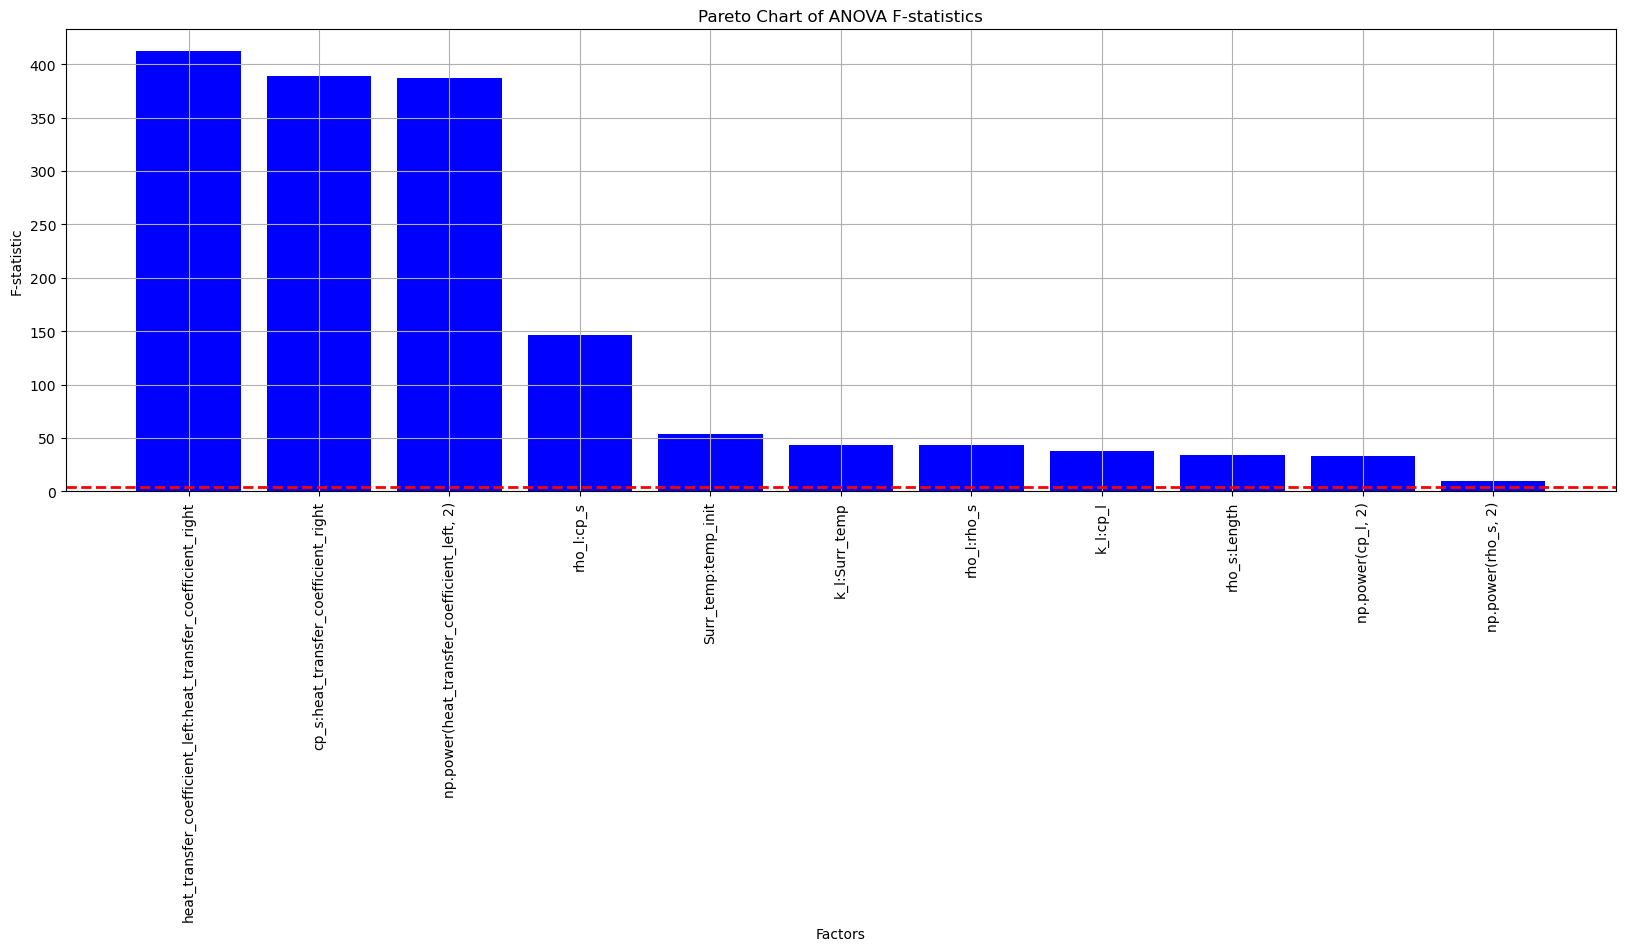

In [224]:
from scipy.stats import f
anova_results7 = sm.stats.anova_lm(model11, typ=2)

anova_results_df2 = anova_results7.reset_index()

# Sort by the F-statistic or sum of squares for visualization
anova_results_df2 = anova_results_df2.sort_values(by='F', ascending=False)

dfn = anova_results_df2['df'][0]
dfd = model11.df_resid

alpha = 0.05
f_critical = f.ppf(1-alpha, dfn, dfd)
# print(f'Critical F-value: {f_critical}')

# Plot the Pareto chart
plt.figure(figsize=(20, 6))
plt.bar(anova_results_df2['index'], anova_results_df2['F'], color='b')
plt.axhline(f_critical, color='r', linestyle='--',linewidth=2)
plt.xlabel('Factors')
plt.ylabel('F-statistic')
plt.title('Pareto Chart of ANOVA F-statistics')
plt.xticks(rotation=90, ha='center')
plt.grid(True)
plt.show()

The plots of the residuals vs. fitted values are shown below


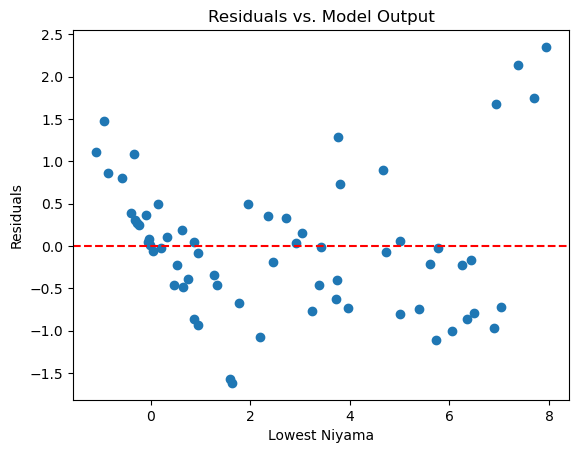

In [216]:
residual11 = model11.resid
Fractional_Factorial_doe_center_pt['Residuals'] =residual5
print (f"The plots of the residuals vs. fitted values are shown below")
# Plot residuals vs. fitted values
plt.scatter(model11.fittedvalues, residual11)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Model Output')
plt.xlabel('Lowest Niyama')
plt.ylabel('Residuals')
plt.show()

In [217]:
mse_residuals = np.mean(residual11**2)
print("Mean Squared Error of Residuals:", mse_residuals)


Mean Squared Error of Residuals: 0.677107261126149


In [218]:
from scipy.stats import shapiro

# Shapiro-Wilk Test
stat, p_value = shapiro(residual11)
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p_value)

if p_value > 0.05:
    print('The residuals are normally distributed (fail to reject H0).')
else:
    print('The residuals are not normally distributed (reject H0).')

Shapiro-Wilk Test Statistic: 0.9606441001378955
p-value: 0.037044713763278087
The residuals are not normally distributed (reject H0).


In [191]:
c1 = sim1d(2533.8, 2628.7, 100.88, 93.31, 1207.94, 934.11, 285.0, 377330.0, 901.0, 10.0, 10.0, 10.0e-3)
c2 = sim1d(2386.2, 2791.3, 100.88, 93.31, 1207.94, 934.11, 285.0, 377330.0, 901.0, 10.0, 10.0, 10.0e-3)
c3 = sim1d(2533.8, 2791.3, 100.88, 93.31, 1207.94, 934.11, 285.0, 377330.0, 901.0, 10.0, 10.0, 10.0e-3)
c4 = sim1d(2386.2, 2791.3, 100.88, 93.31, 1207.94, 991.89, 285.0, 377330.0, 901.0, 10.0, 10.0, 10.0e-3)

print(f'rho_l_high & rho_s_low: {c1}, rho_l_low & rho_s_high: {c2}')
print(f'rho_l_high & cps_s_low: {c3}, rho_l_low & cps_s_high: {c4}')



rho_l_high & rho_s_low: 4.86, rho_l_low & rho_s_high: 2.37
rho_l_high & cps_s_low: 3.09, rho_l_low & cps_s_high: 2.39


In [192]:
c5 = sim1d(2386.2, 2628.7, 100.88, 93.31, 1282.65, 991.8, 285.0, 377330.0, 901.0, 10.0, 10.0, 10.0e-3)
c6 = sim1d(2386.2, 2628.7, 100.88, 93.31, 1207.94, 934.11, 285.0, 377330.0, 901.0, 10.0, 15.0, 10.0e-3)

print(f'cp_s_high & htc_r_low: {c5}, cp_s_low & htc_r_high: {c6}')


cp_s_high & htc_r_low: 2.96, cp_s_low & htc_r_high: 0.57


In [193]:

c7 = sim1d(2386.2, 2628.7, 100.88, 93.31, 1207.94, 934.11, 298.0, 377330.0, 901.0, 10.0, 10.0, 10.0e-3)
c8 = sim1d(2386.2, 2628.7, 100.88, 93.31, 1207.94, 934.11, 285.0, 377330.0, 925.0, 10.0, 10.0, 10.0e-3)

print(f'Surr_temp_high & temp_init_low: {c7}, Surr_temp_low & temp_init_high: {c8}')


Surr_temp_high & temp_init_low: 2.92, Surr_temp_low & temp_init_high: 2.94


In [194]:

c9 = sim1d(2386.2, 2791.3, 100.88, 93.31, 1207.94, 934.11, 285.0, 377330.0, 901.0, 10.0, 10.0, 10.0e-3)
c10 = sim1d(2386.2, 2628.7, 100.88, 93.31, 1207.94, 934.11, 285.0, 377330.0, 901.0, 10.0, 10.0, 20.0e-3)

print(f'rho_s_high & Length_low: {c9}, rho_s_low & Length_high: {c10}')


rho_s_high & Length_low: 2.37, rho_s_low & Length_high: 5.46


In [195]:

c11 = sim1d(2386.2, 2628.7, 107.12, 93.31, 1207.94, 934.11, 285.0, 377330.0, 901.0, 10.0, 10.0, 10.0e-3)
c12 = sim1d(2386.2, 2628.7, 100.88, 93.31, 1282.65, 934.11, 285.0, 377330.0, 901.0, 10.0, 10.0, 10.0e-3)

print(f'k_l_high & cp_l_low: {c11}, k_l_low & cp_l_high: {c12}')


k_l_high & cp_l_low: 2.92, k_l_low & cp_l_high: 2.94


In [196]:

c13 = sim1d(2386.2, 2628.7, 107.12, 99.08, 1207.94, 934.11, 285.0, 377330.0, 901.0, 10.0, 10.0, 10.0e-3)
c14 = sim1d(2386.2, 2628.7, 100.88, 99.08, 1207.94, 934.11, 298.0, 377330.0, 901.0, 10.0, 10.0, 10.0e-3)

print(f'k_l_high & Surrr_temp_low: {c13}, k_l_low & Surrr_temp_high: {c14}')


k_l_high & Surrr_temp_low: 2.79, k_l_low & Surrr_temp_high: 2.8


In [197]:

c15 = sim1d(2386.2, 2791.3, 100.88, 99.08, 1207.94, 934.11, 285.0, 377330.0, 901.0, 10.0, 10.0, 10.0e-3)
c16 = sim1d(2386.2, 2628.7, 100.88, 99.08, 1207.94, 934.11, 285.0, 377330.0, 901.0, 10.0, 10.0, 10.0e-3)

print(f'rho_s_high :{c15}, rho_s_low :{c16}')

rho_s_high :2.27, rho_s_low :2.81


In [198]:
c17 = sim1d(2386.2, 2628.7, 100.88, 99.08, 1207.94, 934.11, 285.0, 377330.0, 901.0, 15.0, 10.0, 10.0e-3)
c18 = sim1d(2386.2, 2628.7, 100.88, 99.08, 1207.94, 934.11, 285.0, 377330.0, 901.0, 10.0, 15.0, 10.0e-3)

print(f'htc_l_high & htc_r_low  :{c15}, htc_l_low & htc_r_high  :{c16}')

htc_l_high & htc_r_low  :2.27, htc_l_low & htc_r_high  :2.81


In [199]:
c19 = sim1d(2386.2, 2628.7, 100.88, 99.08, 1282.65, 934.11, 285.0, 377330.0, 901.0, 10.0, 10.0, 10.0e-3)
c20 = sim1d(2386.2, 2628.7, 100.88, 99.08, 1207.94, 934.11, 285.0, 377330.0, 901.0, 15.0, 10.0, 15.0e-3)

print(f'cp_l_high &htc_l_low  :{c19}, cp_l_low & htc_l_high  :{c20}')

cp_l_high &htc_l_low  :2.81, cp_l_low & htc_l_high  :0.01


/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.9/site-packages/statsmodels/graphics/factorplots.py:113: FutureWarning: The provided callable <function mean at 0x7fbb0c76fe50> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  plot_data = data.groupby(['trace', 'x']).aggregate(func).reset_index()


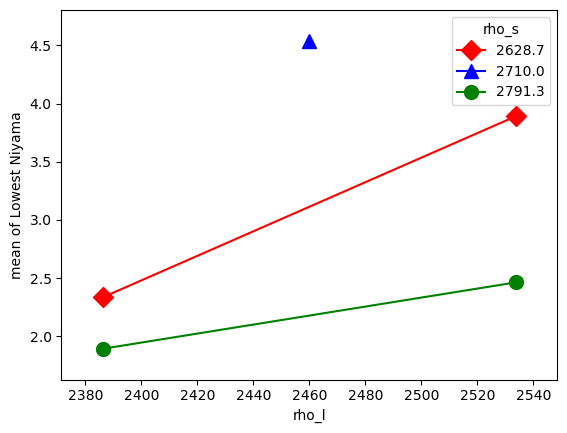

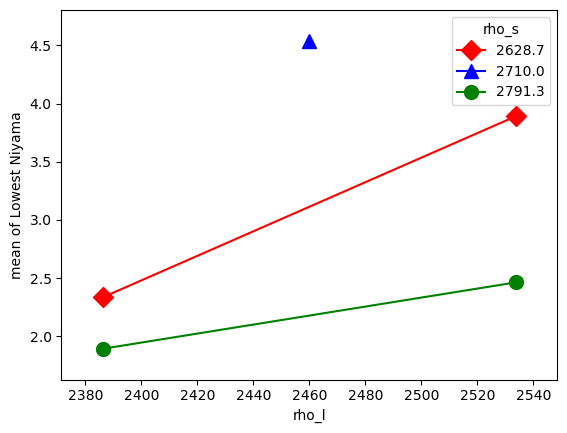

In [223]:
from statsmodels.graphics.factorplots import interaction_plot
interaction_plot(
    x = Fractional_Factorial_doe_center_pt['rho_l'],
    trace = Fractional_Factorial_doe_center_pt['rho_s'],
    response = Fractional_Factorial_doe_center_pt['Lowest_Niyama'],
    func = np.mean,
    colors=['red', 'blue', 'green'],
    markers=['D', '^', 'o'],
    markersize=10,
    xlabel='rho_l',
    ylabel='Lowest Niyama',
    legendtitle='rho_s',
    legendloc='best',
    
    
)

/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.9/site-packages/statsmodels/graphics/factorplots.py:113: FutureWarning: The provided callable <function mean at 0x7fbb0c76fe50> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  plot_data = data.groupby(['trace', 'x']).aggregate(func).reset_index()


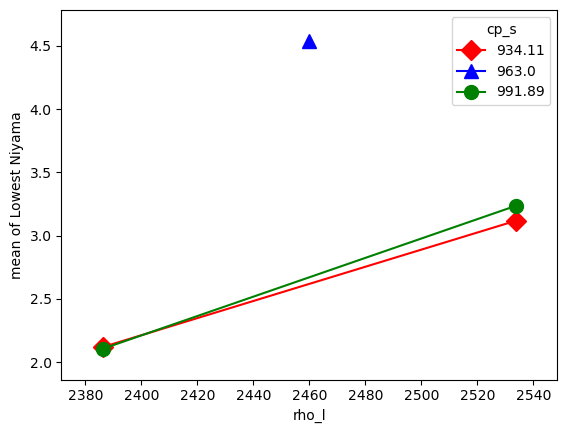

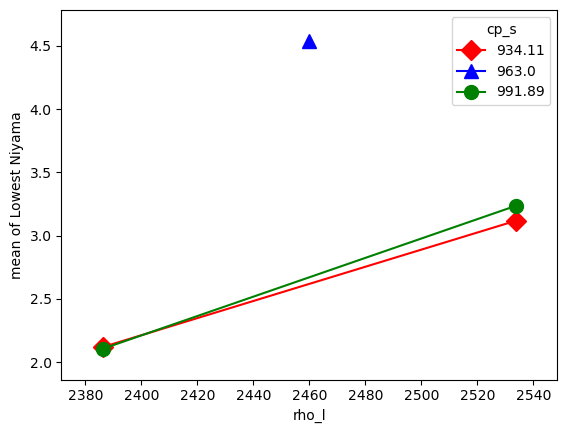

In [226]:
interaction_plot(
    x = Fractional_Factorial_doe_center_pt['rho_l'],
    trace = Fractional_Factorial_doe_center_pt['cp_s'],
    response = Fractional_Factorial_doe_center_pt['Lowest_Niyama'],
    func = np.mean,
    colors=['red', 'blue', 'green'],
    markers=['D', '^', 'o'],
    markersize=10,
    xlabel='rho_l',
    ylabel='Lowest Niyama',
    legendtitle='cp_s',
    legendloc='best',
)

/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.9/site-packages/statsmodels/graphics/factorplots.py:113: FutureWarning: The provided callable <function mean at 0x7fbb0c76fe50> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  plot_data = data.groupby(['trace', 'x']).aggregate(func).reset_index()


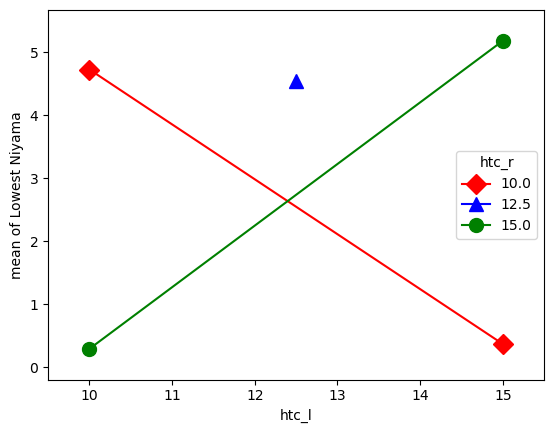

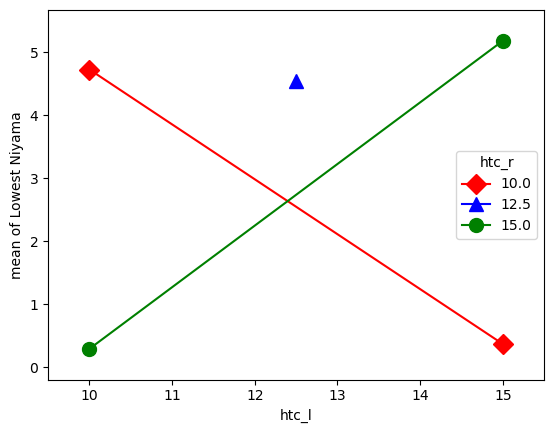

In [228]:
interaction_plot(
    x = Fractional_Factorial_doe_center_pt['heat_transfer_coefficient_left'],
    trace = Fractional_Factorial_doe_center_pt['heat_transfer_coefficient_right'],
    response = Fractional_Factorial_doe_center_pt['Lowest_Niyama'],
    func = np.mean,
    colors=['red', 'blue', 'green'],
    markers=['D', '^', 'o'],
    markersize=10,
    xlabel='htc_l',
    ylabel='Lowest Niyama',
    legendtitle='htc_r',
    legendloc='best',
)

/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.9/site-packages/statsmodels/graphics/factorplots.py:113: FutureWarning: The provided callable <function mean at 0x7fbb0c76fe50> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  plot_data = data.groupby(['trace', 'x']).aggregate(func).reset_index()


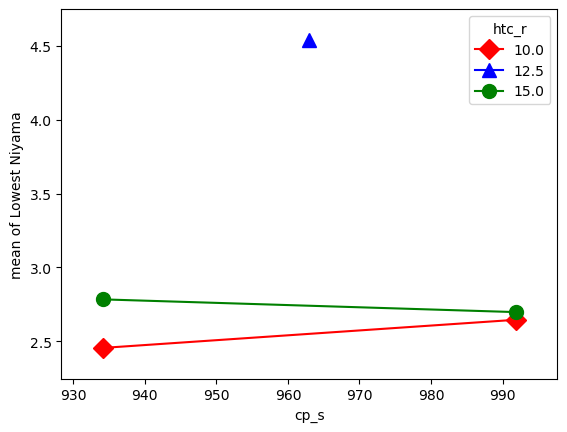

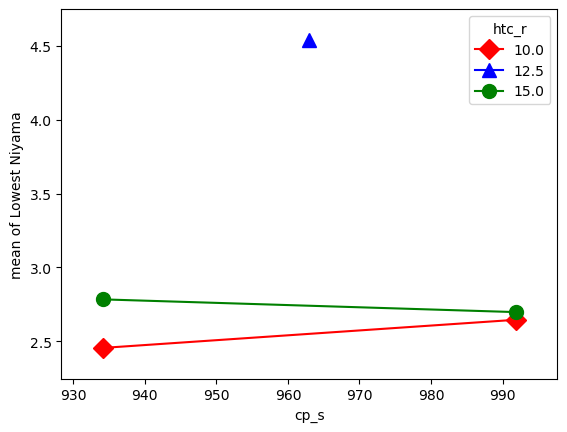

In [229]:
interaction_plot(
    x = Fractional_Factorial_doe_center_pt['cp_s'],
    trace = Fractional_Factorial_doe_center_pt['heat_transfer_coefficient_right'],
    response = Fractional_Factorial_doe_center_pt['Lowest_Niyama'],
    func = np.mean,
    colors=['red', 'blue', 'green'],
    markers=['D', '^', 'o'],
    markersize=10,
    xlabel='cp_s',
    ylabel='Lowest Niyama',
    legendtitle='htc_r',
    legendloc='best',
)

/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.9/site-packages/statsmodels/graphics/factorplots.py:113: FutureWarning: The provided callable <function mean at 0x7fbb0c76fe50> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  plot_data = data.groupby(['trace', 'x']).aggregate(func).reset_index()


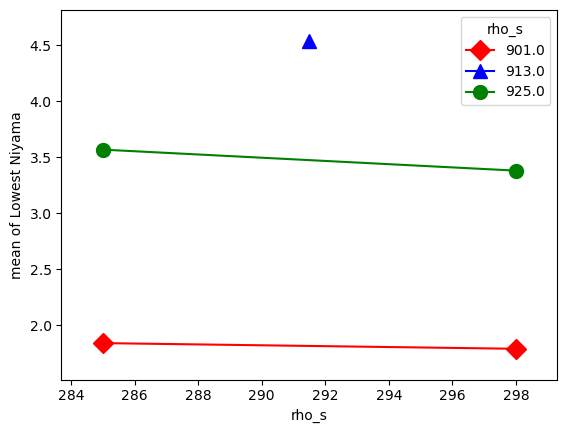

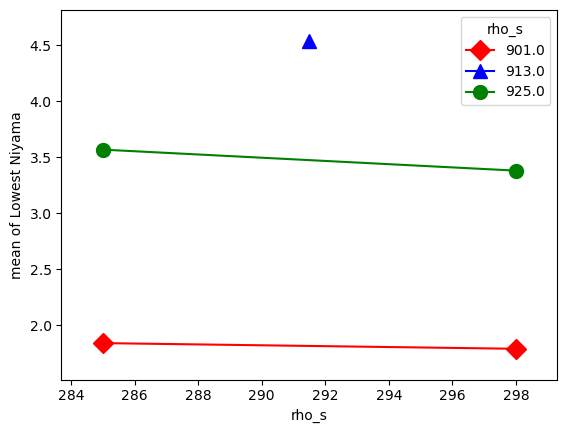

In [232]:
interaction_plot(
    x = Fractional_Factorial_doe_center_pt['Surr_temp'],
    trace = Fractional_Factorial_doe_center_pt['temp_init'],
    response = Fractional_Factorial_doe_center_pt['Lowest_Niyama'],
    func = np.mean,
    colors=['red', 'blue', 'green'],
    markers=['D', '^', 'o'],
    markersize=10,
    xlabel='rho_s',
    ylabel='Lowest Niyama',
    legendtitle='rho_s',
    legendloc='best',
)

/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.9/site-packages/statsmodels/graphics/factorplots.py:113: FutureWarning: The provided callable <function mean at 0x7fbb0c76fe50> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  plot_data = data.groupby(['trace', 'x']).aggregate(func).reset_index()


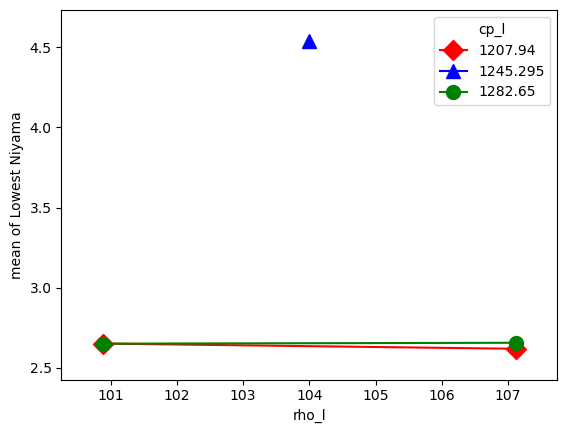

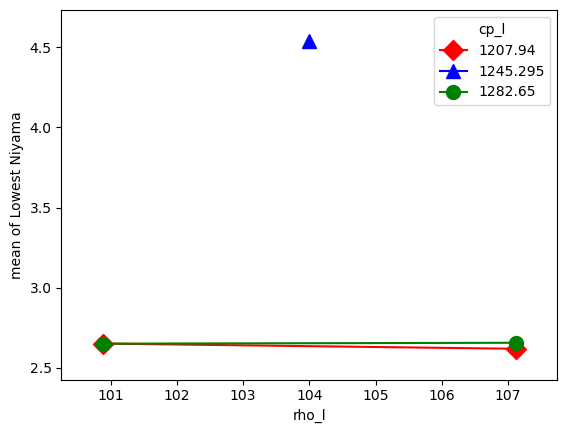

In [233]:
interaction_plot(
    x = Fractional_Factorial_doe_center_pt['k_l'],
    trace = Fractional_Factorial_doe_center_pt['cp_l'],
    response = Fractional_Factorial_doe_center_pt['Lowest_Niyama'],
    func = np.mean,
    colors=['red', 'blue', 'green'],
    markers=['D', '^', 'o'],
    markersize=10,
    xlabel='rho_l',
    ylabel='Lowest Niyama',
    legendtitle='cp_l',
    legendloc='best',
)